<a href="https://colab.research.google.com/github/Fabian-lewis/medical-diagnostic-pricing-audit/blob/main/diagnosis_probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives
Prove that:

    1. Smokers cost more on average (baseline)

    2. BUT that average hides the real issue

    3. The real cost difference explodes only at high BMI

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load the data

from google.colab import files

# upload the data
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Read the file
df = pd.read_csv(filename)

# Copy the data
data = df.copy()

data.head()

Saving cleaned_insurance_data.csv to cleaned_insurance_data.csv


,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,smoker_binary,bmi_category,bmi_smoker_interaction
0,0,19,female,27.900,0,yes,southwest,16884.92400,1,Overweight,27.9
1,1,18,male,33.770,1,no,southeast,1725.55230,0,Obese,0.0
2,2,28,male,33.000,3,no,southeast,4449.46200,0,Obese,0.0
3,3,33,male,22.705,0,no,northwest,21984.47061,0,Normal,0.0
4,4,32,male,28.880,0,no,northwest,3866.85520,0,Overweight,0.0


In [4]:
# Convert Sex & Region to Categorical
data['sex'] = data['sex'].astype('category')
data['region'] = data['region'].astype('category')

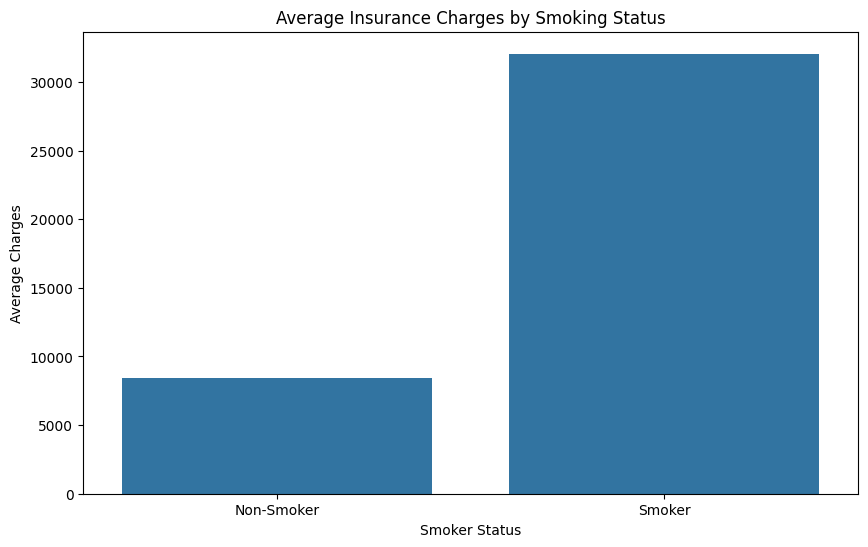




--------------------------------------------------------------------------------
  smoker_binary       charges
0    Non-Smoker   8434.268298
1        Smoker  32050.231832


In [14]:
## Step 1: Baseline Comparison
overall_avg = (
    data
    .groupby('smoker_binary')['charges']
    .mean()
    .reset_index()
)

overall_avg['smoker_binary'] = overall_avg['smoker_binary'].map({0: 'Non-Smoker', 1: 'Smoker'})

# Plot the averages
plt.figure(figsize=(10, 6))
sns.barplot(
    data=overall_avg,
    x='smoker_binary',
    y='charges'
)

plt.title('Average Insurance Charges by Smoking Status')
plt.xlabel('Smoker Status')
plt.ylabel('Average Charges')
plt.show()

# print the dataframe
print("\n\n")
print("-"*80)
print(overall_avg)

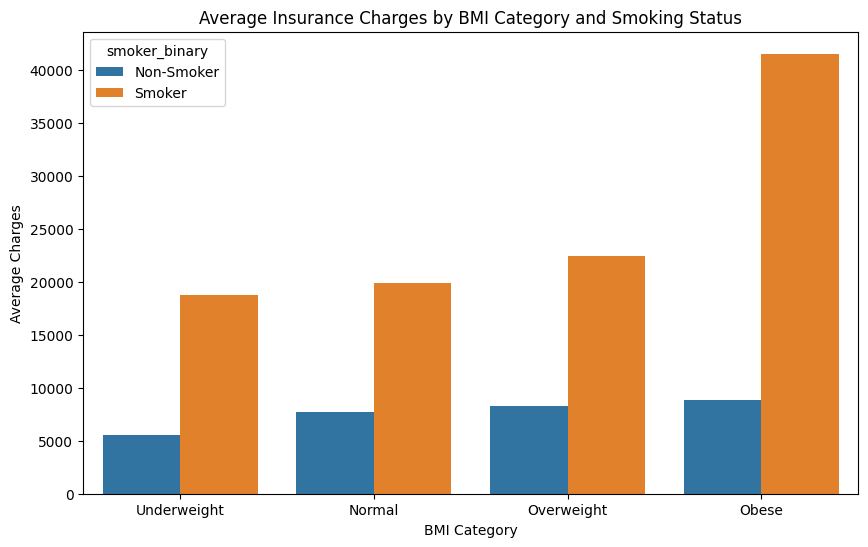

In [24]:
## Average Charges by BMI Band & Smoking Status
bmi_smoker_avg = (
    data
    .groupby(['bmi_category', 'smoker_binary'])['charges']
    .mean()
    .reset_index()

)

# Order the BMI Category
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']

bmi_smoker_avg['bmi_category'] = pd.Categorical(
    bmi_smoker_avg['bmi_category'],
    categories=bmi_order,
    ordered=True
)

bmi_smoker_avg['smoker_binary'] = bmi_smoker_avg['smoker_binary'].map({0: 'Non-Smoker', 1: 'Smoker'})

bmi_smoker_avg = bmi_smoker_avg.sort_values(
    by=['bmi_category', 'smoker_binary']
)


# plot the average
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bmi_smoker_avg,
    x='bmi_category',
    y='charges',
    hue='smoker_binary'
)

plt.title('Average Insurance Charges by BMI Category and Smoking Status')
plt.xlabel('BMI Category')
plt.ylabel('Average Charges')
plt.show()

In [32]:
## Summary Table
summary_table = data.pivot_table(
    values='charges',
    index='bmi_category',
    columns='smoker_binary',
    aggfunc=['mean']
)

# Order the bmi category
summary_table = summary_table.reindex(
    index=bmi_order
)

# Rename the columns
summary_table = summary_table.rename(
    columns={0: 'Non-Smoker Avg', 1: 'Smoker Avg'}
)

summary_table

mean              
smoker_binary Non-Smoker Avg    Smoker Avg
bmi_category                              
Underweight      5532.992453  18809.824980
Normal           7685.656014  19942.223641
Overweight       8257.961955  22495.874163
Obese            8842.691548  41557.989840

In [30]:
## Quantify the Cliff

# Absolute Difference
summary_table['Absolute_Difference'] = (
    summary_table['Smoker Avg'] - summary_table['Non-Smoker Avg']
)

# Percentage Difference
summary_table['Percent_Increase'] = (
    summary_table['Absolute_Difference'] / summary_table['Non-Smoker Avg']
) * 100

summary_table


smoker_binary,Non-Smoker Avg,Smoker Avg,Absolute_Difference,Percent_Increase
bmi_category,,,,
Underweight,5532.992453,18809.824980,13276.832527,239.957539
Normal,7685.656014,19942.223641,12256.567627,159.473279
Overweight,8257.961955,22495.874163,14237.912208,172.414359
Obese,8842.691548,41557.989840,32715.298292,369.969914


In [41]:
## Verify the stats
summary = data.pivot_table(
    values='charges',
    index='bmi_category',
    columns='smoker_binary',
    aggfunc=['mean', 'median','std','count']
)

# Order the bmi category
summary = summary.reindex(
    index=bmi_order
)

# Rename the columns
summary = summary.rename(
    columns={0: 'Non-Smoker', 1: 'Smoker'}
)

summary

mean                   median                       std  \
smoker_binary   Non-Smoker        Smoker Non-Smoker       Smoker   Non-Smoker   
bmi_category                                                                    
Underweight    5532.992453  18809.824980  3732.6251  15006.57945  3897.207878   
Normal         7685.656014  19942.223641  6593.5083  19479.90370  5828.662919   
Overweight     8257.961955  22495.874163  7063.9157  21215.43300  5900.928224   
Obese          8842.691548  41557.989840  8076.0524  40904.19950  6104.794030   

                                count         
smoker_binary       Smoker Non-Smoker Smoker  
bmi_category                                  
Underweight    8110.514545         15      5  
Normal         4202.479709        175     50  
Overweight     5140.560576        312     74  
Obese          6031.473681        562    145

### Summary Insight

1. Mean VS Median (Obese Group)

| Metric | Non-Smoker | Smoker      |
| ------ | ---------- | ----------- |
| Mean   | ~8,843     | **~41,558** |
| Median | ~8,076     | **~40,904** |
| Count  | 562        | 145         |


From the table above

    Mean ≈ Median for obese smokers

    This means:

     - The high costs are systematic
     - Not driven by a few extreme cases
     - The entire obese-smoker distribution is shifted upward

Note:

    If smoking were just a flat surcharge:

    The difference between smoker and non-smoker would be similar across BMI bands

    The gap explodes at obesity

    BMI increases cost modestly for non-smokers,
    but *dramatically for smokers.


2. Variability (Std Dev)

Comparing Obese smokers and Over-weight Smokers:

    Even thoough the cost rises by almost double
    most people are clustered around the average
    
    Obese smokers are more expensive,
    but their costs are still predictable —
    which makes them easier to price and manage.

 3. Underweight Category

 | Group                  | Count |
| ---------------------- | ----- |
| Underweight Non-Smoker | 15    |
| Underweight Smoker     | 5     |


Key Take away here

    1. Very small sample

    2. High mean & std are expected

    3. Not reliable for pricing decisions

    Underweight smokers show high average costs,
    but the small sample size introduces high uncertainty;


#### Final Take Away

    While smokers incur higher costs across all BMI categories,
    
    the cost differential increases sharply with BMI.
    
    Among obese individuals, both mean and median charges for smokers are nearly five times those of non-smokers,
    
    indicating a strong and systematic interaction between smoking and obesity that is masked in aggregate averages.